In [1]:
!pip install schemaorg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 4.0 MB/s 
  Created wheel for schemaorg: filename=schemaorg-0.1.1-py3-none-any.whl size=7116127 sha256=79cdb744912b46e55ea81a80478e736a5df6ceccfa4d4638eb483ba1d8191744
  Stored in directory: /root/.cache/pip/wheels/8d/8c/ca/50f8afdf3e0fb523b70ab6cb80eaccdcfc4a35a0bcab0191dd
Successfully built schemaorg


In [128]:
from schemaorg.main import Schema
import uuid,sys
from enum import Enum, auto
import json
import joblib
import os,sys

# Inspiration from: https://stackoverflow.com/questions/69125694/dynamically-add-overwrite-the-setter-and-getter-of-property-attributes
class Pattern:
  def __init__(self):
    self.id = uuid.uuid4().hex

  def getId(self):
      return self.id

class NodeType(Enum): # look into schema.org and open-meta
  ORGANIZATION = auto()
  PERSON = auto()
  THING = auto()
  DIGITALDOCUMENT = auto()

  def getName(self):
    if self.name==self.DIGITALDOCUMENT.name:
      return "DigitalDocument"
    if self.name==self.THING.name:
      return "Thing"
    if self.name==self.PERSON.name:
      return "Person"
    if self.name==self.ORGANIZATION.name:
      return "Organization"

class Node(Pattern):
  def __init__(self,nodeType: NodeType):
    Pattern.__init__(self)
    # From schema.org get the list of fields
    self.attributes={}

    self.attributes["NodeType"]=nodeType
    
    # sys.stdout = open(os.devnull, "w")
    # sys.stderr = open(os.devnull, "w")
    spec = Schema(nodeType.getName())
    # sys.stdout = sys.__stdout__
    # sys.stderr = sys.__stderr__
    # add fields
    for name, meta in spec._properties.items():
      self.attributes[name]=meta

  def getAttributesList(self):
    return self.attributes.keys()

  def getAttribute(self,name):
    if name in self.attributes.keys():
      return self.attributes[name]
    else:
      return "Buddy. Yo... That's not a thing bro!"
  
  def setAttribute(self,name,value):
    if name in self.attributes.keys():
      self.attributes[name]=value
      return True
    else:
      return "Buddy. Yo... That's not a thing bro!"

class NodeRelationshipMultiplicityConstraint(Enum):
  ONE_TO_ONE_OR_MORE = auto()
  ONE_TO_ZERO_OR_MORE = auto()
  MANY_TO_MANY = auto() # need an example

#TODO: get bigger list from @giselle
class NodeRelationshipType(Enum):
  SCO = auto()
  HAS_TYPE = auto() # (maybe merge with SCO?)

class NodeRelationship(Pattern):
  def __init__(self,
               nodeRelationshipType:NodeRelationshipType,
               multiplicity:NodeRelationshipMultiplicityConstraint,
               sourceNodeId:str,    # in a taxonomy this is another taxonomy node, not a "real" node in the Knowledge Graph
               targetNodeId:str,    # in a taxonomy this is another taxonomy node, not a "real" node in the Knowledge Graph
               relationshipPropertyValue,       # a number (or string?) that annotates the relationship
               predictionConfidence #must be able to be null in a taxonomy
               ):
    Pattern.__init__(self)
    self.nodeRelationshipType = nodeRelationshipType
    self.multiplicity=multiplicity
    self.sourceNodeId=sourceNodeId
    self.targetNodeId=targetNodeId
    self.relationshipPropertyValue=relationshipPropertyValue
    self.predictionConfidence=predictionConfidence

  def getNodeRelationshipType(self):
    return self.nodeRelationshipType

  def getMultiplicity(self):
    return self.multiplicity

  def getSourceNodeId(self):
    return self.sourceNodeId

  def getTargetNodeId(self):
    return self.targetNodeId

  def getRelationshipPropertyValue(self):
    return self.relationshipPropertyValue

  def getPredictionConfidence(self):
    return self.predictionConfidence

  def getAttributesList(self):
    return {"nodeRelationshipType"     :self.getNodeRelationshipType(),
            "multiplicity"             :self.getMultiplicity(),
            "sourceNodeId"             :self.getSourceNodeId(),
            "targetNodeId"             :self.getTargetNodeId(),
            "relationshipPropertyValue":self.getRelationshipPropertyValue(),
            "predictionConfidence"     :self.getPredictionConfidence(),
            }

class Constraint(Pattern):
  def __init__(self,
               constrainedAttributeName:str,
               constraintDefinition):
    Pattern.__init__(self)
    self.constrainedAttributeName=constrainedAttributeName
    self.constraintDefinition=constraintDefinition

  def getConstrainedAttributeName(self):
    return self.constrainedAttributeName

  def getConstraintDefinition(self):
    return self.constraintDefinition

class NodeConstraint(Constraint):
  def __init__(self,
               affectedNodeId:str,
               nodeType: NodeType,
               constrainedAttributeName:str,
               constraintDefinition):
    Constraint.__init__(self,constrainedAttributeName,constraintDefinition)
    self.nodeType=nodeType
    self.affectedNodeId=affectedNodeId
    self.constrainedAttributeName=constrainedAttributeName
    self.constraintDefinition=constraintDefinition
    # Validate that the constraint type is of the valid name and type for this node type
    if not constrainedAttributeName in Node(nodeType).getAttributesList():
      raise TypeError(f"Attribute {constrainedAttributeName} does not exist for the nodeType {nodeType}.")
    # TODO: See rangeIncludes in the schema, and the definitions here: https://partsol.atlassian.net/wiki/spaces/CHKM/pages/6226060/Query+Builder
    pass

  def getNodeType(self):
    return self.nodeType

  def geAffectedNodeId(self):
    return self.affectedNodeId

  def getAttributesList(self):
    return {"nodeType":self.getNodeType(),
            "affectedNodeId":self.getAffectedNodeId(),
            "constrainedAttributeName":self.getConstrainedAttributeName(),
            "constraintDefinition":self.getConstraintDefinition()
            }

class RelationshipConstraint(Constraint):
  def __init__(self,
               affectedRelationshipId:str,
               relationshipType: NodeRelationshipType,
               constrainedAttributeName:str,
               constraintDefinition):
    Constraint.__init__(self,constrainedAttributeName,constraintDefinition)
    self.relationshipType=relationshipType
    self.affectedRelationshipId=affectedRelationshipId
    # Validate that the constraint type is of the valid name and type for this node type
    nr=NodeRelationship(relationshipType,
                        NodeRelationshipMultiplicityConstraint.MANY_TO_MANY,
                        sourceNodeId=" ",
                        targetNodeId=" ",
                        relationshipPropertyValue=123,
                        predictionConfidence=.123456)
    if not constrainedAttributeName in nr.getAttributesList().keys():
      raise TypeError(f"Attribute {constrainedAttributeName} does not exist for the relationshipType {relationshipType}.")
    # TODO: See rangeIncludes in the schema, and the definitions here: https://partsol.atlassian.net/wiki/spaces/CHKM/pages/6226060/Query+Builder
    pass

  def getRelationshipType(self):
    return self.relationshipType

  def getAffectedRelationshipId(self):
    return self.affectedRelationshipId

  def getAttributesList(self):
    return {"relationshipType":self.getRelationshipType(),
            "affectedRelationshipId":self.getAffectedRelationshipId(),
            "constrainedAttributeName":self.getConstrainedAttributeName(),
            "constraintDefinition":self.getConstraintDefinition()
            }

# A Taxonomy is a graph with a unique id
# TODO: A Taxonomy search has a state indicating which nodes we are at (active nodes)
# TODO: Active nodes each create an expansion query against the graph
# TODO: Graph nodes are marked with the identity of the expansion query node(s) that made them
# TODO: Data source queries are also triggered by expansion queries. It's a special case of the expansion query....

# Constrain each step of the search. This is a stateful "graph" guiding the search
class Taxonomy(Pattern):
  def __init__(self,
               taxonomyNodes:[Node],
               taxonomyRelationships:[NodeRelationship],
               nodeConstraints:[NodeConstraint],
               relationshipConstraints:[RelationshipConstraint]):
    Pattern.__init__(self)
    self.taxonomyNodes=taxonomyNodes
    self.taxonomyRelationships=taxonomyRelationships
    self.nodeConstraints=nodeConstraints
    self.relationshipConstraints=relationshipConstraints
  
  def getTaxonomyNodes(self):
    return self.taxonomyNodes

  def getTaxonomyRelationships(self):
    return self.taxonomyRelationships

  def getNodeConstraints(self):
    return self.nodeConstraints

  def getRelationshipConstraints(self):
    return self.relationshipConstraints

  def getJson(self):
    response = {}
    response["nodes"]={}
    for node in self.taxonomyNodes:
      attributes={}
      for attribute in node.getAttributesList():
        attributes[attribute]=node.getAttribute(attribute)
      response["nodes"][node.getId()]=attributes

    response["relationships"]={}
    for relationship in self.taxonomyRelationships:
      attributes=relationship.getAttributesList()
      response["relationships"][relationship.getId()]=attributes
    
    response["nodeConstraints"]=[n.getAttributesList() for n in self.nodeConstraints]
    response["relationshipConstraints"]=[r.getAttributesList() for r in self.relationshipConstraints]

    return response

  def appendNodeConstraint(self,newConstraint:NodeConstraint):
    #TODO: must not override taxonomy constraints (can make results set more narrow, but cannot make more broad)
    self.nodeConstraints.append(newConstraint)
    pass

  def appendRelationshipConstraint(self,newConstraint:RelationshipConstraint):
    #TODO: must not override taxonomy constraints (can make results set more narrow, but cannot make more broad)
    self.relationshipConstraints.append(newConstraint)
    pass

In [129]:

# Do iterative (recursive) STATEFUL searching. The state of the search is the state of the nodes in the taxonomy
class Search(Pattern):
  def __init__(self,
               taxonomyId:str,
               searchNodeConstraints:[NodeConstraint],
               searchRelationshipConstraints:[RelationshipConstraint]):
    Pattern.__init__(self)
    self.taxonomyId = taxonomyId
    self.taxonomyInstance = self.loadTaxonomy(taxonomyId)
    for nodeConstraint in searchNodeConstraints:
      self.addNodeConstraint(nodeConstraint)
    for relationshipConstraint in searchRelationshipConstraints:
      self.addRelationshipConstraint(relationshipConstraint)

  def loadTaxonomy(self,taxonomyId):
    return joblib.load(f"taxonomy_{taxonomyId}.joblib")

  def getTaxonomyId(self):
    return self.taxonomyId

  def addNodeConstraint(self,nodeConstraint:NodeConstraint):
    #TODO: must not override taxonomy constraints (can make results set more narrow, but cannot make more broad)
    self.taxonomyInstance.appendNodeConstraint(nodeConstraint)
    pass

  def addRelationshipConstraint(self,relationshipConstraint:RelationshipConstraint):
    #TODO: must not override taxonomy constraints (can make results set more narrow, but cannot make more broad)
    self.taxonomyInstance.appendRelationshipConstraint(relationshipConstraint)
    pass

  def knowledgeGraphDiscoveryQueryStep(self):
    # Expansion query
    #TODO: run cypher query on graph to see what nodes we will expand upon
    #TODO: if this is the first iteration of this search: join results of the query with root node query data
    #TODO: call APIs to get data on joined query results
    #TODO: exit condition: no more nodes left, or max steps/depth reached
    pass

In [130]:
# TODO: Fill this in and create the 3 use cases we care about for the Alpha release + the Taco example
availableTaxonomies=[]

# NodeRelationship(NodeRelationshipType.SCO,
#                  NodeRelationshipMultiplicityConstraint.ONE_TO_ONE_OR_MORE,
#                  sourceNodeId="ajhsd",
#                  targetNodeId="kjbadf",
#                  relationshipPropertyValue=4,
#                  predictionConfidence=0.7).getAttributesList()
# # RelationshipConstraint().getAttributesList()

# taxonomyPersonNode1 = TaxonomyPersonNode()
# taxonomyPersonNode1.getId()
# dir(taxonomyPersonNode1)
personNode1 = Node(NodeType.PERSON)
orgNode1 = Node(NodeType.ORGANIZATION)
objNode1 = Node(NodeType.THING)
objNode1.getAttributesList()
# personNode1.getAttribute("NodeType")
# personNode1.getAttribute("address")
aRelationship = NodeRelationship(NodeRelationshipType.SCO,NodeRelationshipMultiplicityConstraint.ONE_TO_ONE_OR_MORE,objNode1.getId(),orgNode1.getId(),123,.7)

aRelationship.getMultiplicity()

anotherRelationship = NodeRelationship(NodeRelationshipType.SCO,NodeRelationshipMultiplicityConstraint.ONE_TO_ONE_OR_MORE,personNode1.getId(),orgNode1.getId(),123,.7)

exampleNodeConstraint = NodeConstraint(affectedNodeId=orgNode1.getId(),
                                       nodeType=orgNode1.getAttribute("NodeType"),
                                       constrainedAttributeName="name",
                                       constraintDefinition="like '%daniel%'")

# print("TEST",dir(anotherRelationship))
relType = anotherRelationship.getNodeRelationshipType()
relId = anotherRelationship.getId()
exampleRelationshipConstraint = RelationshipConstraint(relId,relType,'relationshipPropertyValue',">5")

t = Taxonomy([personNode1,orgNode1],[anotherRelationship],[],[])
dir(t)
t.getJson()

joblib.dump(t,f"taxonomy_{t.getId()}.joblib")

s = Search(t.getId(),[],[])
dir(s)
s.getId()

Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Person
Person: found 74 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Organization
Organization: found 76 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Organization
Organization: found 76 properties


'1bc72ddbe43a4cc3a12540d66d103605'

In [131]:
personNode1.getAttributesList()

dict_keys(['NodeType', 'additionalName', 'additionalType', 'address', 'affiliation', 'alternateName', 'alumniOf', 'award', 'awards', 'birthDate', 'birthPlace', 'brand', 'callSign', 'children', 'colleague', 'colleagues', 'contactPoint', 'contactPoints', 'deathDate', 'deathPlace', 'description', 'disambiguatingDescription', 'duns', 'email', 'familyName', 'faxNumber', 'follows', 'funder', 'gender', 'givenName', 'globalLocationNumber', 'hasCredential', 'hasOccupation', 'hasOfferCatalog', 'hasPOS', 'height', 'homeLocation', 'honorificPrefix', 'honorificSuffix', 'identifier', 'image', 'interactionStatistic', 'isicV4', 'jobTitle', 'knows', 'knowsAbout', 'knowsLanguage', 'mainEntityOfPage', 'makesOffer', 'memberOf', 'naics', 'name', 'nationality', 'netWorth', 'owns', 'parent', 'parents', 'performerIn', 'potentialAction', 'publishingPrinciples', 'relatedTo', 'sameAs', 'seeks', 'sibling', 'siblings', 'sponsor', 'spouse', 'subjectOf', 'taxID', 'telephone', 'url', 'vatID', 'weight', 'workLocation'

In [132]:
orgNode1.getAttributesList()

dict_keys(['NodeType', 'actionableFeedbackPolicy', 'additionalType', 'address', 'aggregateRating', 'alternateName', 'alumni', 'areaServed', 'award', 'awards', 'brand', 'contactPoint', 'contactPoints', 'correctionsPolicy', 'department', 'description', 'disambiguatingDescription', 'dissolutionDate', 'diversityPolicy', 'diversityStaffingReport', 'duns', 'email', 'employee', 'employees', 'ethicsPolicy', 'event', 'events', 'faxNumber', 'founder', 'founders', 'foundingDate', 'foundingLocation', 'funder', 'globalLocationNumber', 'hasCredential', 'hasMerchantReturnPolicy', 'hasOfferCatalog', 'hasPOS', 'hasProductReturnPolicy', 'identifier', 'image', 'interactionStatistic', 'isicV4', 'knowsAbout', 'knowsLanguage', 'legalName', 'leiCode', 'location', 'logo', 'mainEntityOfPage', 'makesOffer', 'member', 'memberOf', 'members', 'naics', 'name', 'nonprofitStatus', 'numberOfEmployees', 'ownershipFundingInfo', 'owns', 'parentOrganization', 'potentialAction', 'publishingPrinciples', 'review', 'reviews',

In [133]:
attrs = Node(NodeType.DIGITALDOCUMENT).getAttributesList()
list(attrs)

Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/DigitalDocument
DigitalDocument: found 121 properties


['NodeType',
 'about',
 'abstract',
 'accessMode',
 'accessModeSufficient',
 'accessibilityAPI',
 'accessibilityControl',
 'accessibilityFeature',
 'accessibilityHazard',
 'accessibilitySummary',
 'accountablePerson',
 'acquireLicensePage',
 'additionalType',
 'aggregateRating',
 'alternateName',
 'alternativeHeadline',
 'assesses',
 'associatedMedia',
 'audience',
 'audio',
 'author',
 'award',
 'awards',
 'character',
 'citation',
 'comment',
 'commentCount',
 'conditionsOfAccess',
 'contentLocation',
 'contentRating',
 'contentReferenceTime',
 'contributor',
 'copyrightHolder',
 'copyrightNotice',
 'copyrightYear',
 'correction',
 'creativeWorkStatus',
 'creator',
 'creditText',
 'dateCreated',
 'dateModified',
 'datePublished',
 'description',
 'disambiguatingDescription',
 'discussionUrl',
 'editEIDR',
 'editor',
 'educationalAlignment',
 'educationalLevel',
 'educationalUse',
 'encoding',
 'encodingFormat',
 'encodings',
 'exampleOfWork',
 'expires',
 'fileFormat',
 'funder',
 'g

In [134]:
anotherRelationship.getAttributesList()

{'nodeRelationshipType': <NodeRelationshipType.SCO: 1>,
 'multiplicity': <NodeRelationshipMultiplicityConstraint.ONE_TO_ONE_OR_MORE: 1>,
 'sourceNodeId': '688c5fd0fe2a42be8a260037f88d4fd7',
 'targetNodeId': '03d44767d5c24c4495382408f574fe58',
 'relationshipPropertyValue': 123,
 'predictionConfidence': 0.7}

In [135]:
attrs = Node(NodeType.THING).getAttributesList()
list(attrs)

Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties


['NodeType',
 'additionalType',
 'alternateName',
 'description',
 'disambiguatingDescription',
 'identifier',
 'image',
 'mainEntityOfPage',
 'name',
 'potentialAction',
 'sameAs',
 'subjectOf',
 'url']

In [136]:
print(NodeType.PERSON.getName())

Person


In [137]:
# taco:
# - taco:THING
# -- 1 or more (subComponentOf SCO): shell: THING
# -- 1 or more (subComponentOf SCO): filling
# ----->0 or more (hasType): beef
# ---------->0 or more (hasType): ground ===
# ----------------> 0 or more (hasType): raw ===
# ----------------> 0 or more (hasType): cooked ===
# ----------------------> 0 or more (hasType): fried ===
# ----------------------> 0 or more (hasType): slow cooked===
# ----------------------> 0 or more (hasType): microwaved ===
# ----------------------> 0 or more (hasType): grilled ===
# ---------->0 or more (hasType): sliced ==
# ---------->0 or more (hasType): shredded ===
# ---------->0 or more (hasType): cubed ==
# ---------->0 or more (hasType): pured ==
# ----->0 or more (hasType): fish
# ----->0 or more (hasType): chicken
# ----->0 or more (hasType): pork


def person(name):
  p=Node(NodeType.PERSON)
  p.setAttribute("name",name)
  return p

def org(name):
  o=Node(NodeType.ORGANIZATION)
  o.setAttribute("name",name)
  return o

def thing(name):
  t=Node(NodeType.THING)
  t.setAttribute("name",name)
  return t

def sco1plus(source,dest):
  return NodeRelationship(NodeRelationshipType.SCO,NodeRelationshipMultiplicityConstraint.ONE_TO_ONE_OR_MORE,source.getId(),dest.getId(),None,None)

def sco0plus(source,dest):
  return NodeRelationship(NodeRelationshipType.SCO,NodeRelationshipMultiplicityConstraint.ONE_TO_ZERO_OR_MORE,source.getId(),dest.getId(),None,None)

def createThingTaxonomy(thingList,thingRelationships):
  thingDict={}
  for t in thingList:
    thingDict[t]=thing(t)
  
  relList = []
  for source,dest,relType in thingRelationships:
    # taco has SCO shell
    source=thingDict[source]
    dest=thingDict[dest]
    aRel = relType(source,dest)
    relList.append(aRel)
  
  return Taxonomy([n for n in thingDict.values()],relList,[],[])

thingList=["taco","shell","filling","beef","ground","raw","cooked","fried","slow cooked","microwaved","grilled","sliced","shredded","cubed","pured","fish","chicken","pork",]
thingRelationships = [      ["taco","shell",sco1plus],
                            ["taco","filling",sco1plus],
                            ["filling","beef",sco0plus],
                            ["beef","ground",sco0plus],
                            ["ground","raw",sco0plus],
                            ["ground","cooked",sco0plus],
                            ["cooked","fried",sco0plus],
                            ["cooked","slow cooked",sco0plus],
                            ["cooked","microwaved",sco0plus],
                            ["cooked","grilled",sco0plus],
                            ["beef","sliced",sco0plus],
                            ["beef","shredded",sco0plus],
                            ["beef","cubed",sco0plus],
                            ["beef","pured",sco0plus],
                            ["filling","fish",sco0plus],
                            ["filling","chicken",sco0plus],
                            ["filling","pork",sco0plus],
                            ]

taco_taxonomy = createThingTaxonomy(thingList,thingRelationships)
joblib.dump(taco_taxonomy,f"taxonomy_{taco_taxonomy.getId()}.joblib")

Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.schema.org/Thing
Thing: found 12 properties
Specification base set to https://www.schema.org
Using Version 12.0
Found https://www.sche

['taxonomy_ffff95fbf5d34030b4a52753d91e3def.joblib']

In [138]:
taco_taxonomy.getJson()

{'nodes': {'237dc3cafb60466282d673ecc674c62f': {'NodeType': <NodeType.THING: 3>,
   'additionalType': OrderedDict([('id', 'https://schema.org/additionalType'),
                ('label', 'additionalType'),
                ('comment',
                 "An additional type for the item, typically used for adding more specific types from external vocabularies in microdata syntax. This is a relationship between something and a class that the thing is in. In RDFa syntax, it is better to use the native RDFa syntax - the 'typeof' attribute - for multiple types. Schema.org tools may have only weaker understanding of extra types, in particular those defined externally."),
                ('subPropertyOf',
                 'https://schema.org/http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
                ('equivalentProperty', ''),
                ('subproperties', ''),
                ('domainIncludes', 'https://schema.org/Thing'),
                ('rangeIncludes', 'https://schema.org/URL'),


In [139]:
# Person taxonomy

# helper function - make a recursive and reusable part of the graph

#input: max recursion steps

# Person (another taxonomy for company) PERSON
#   Organization (0 or more) ORGANIZATION
#     Corporate reports DIGITALDOCUMENT (sub-filter on source to force it to be a corp report... e.g. sourceOrganization, publisher, etc)
#       1 Raw Materials recursion (person->document->parts->parts->parts->...raw material)
#       3 M&A (0 or more)
#       Board of directors DIGITALDOCUMENT
#         Person -> Corporate affiliations PAST -> Organization
#         Person -> Corporate affiliations PRESENT -> Organization
#         Person -> EDUCATION -> Organization
#         Person -> MENTORED_BY -> Person
#   3 M&A (0 or more)
#     2 Person ... recursion
#     4 Org ... recursion
#   Document DIGITALDOCUMENT (0 or more)
#     SCO recursion (person->document->parts->parts->parts->...)
#     1 Raw Materials recursion (person->document->parts->parts->parts->...)
#     2 Person entity (anyone mentioned)
#         Person entity recursion ...
#     Organization (0 or more) (M&A)
#       3 M&A (1 or more)
#         2 Person ... recursion
#         4 Org ... recursion
#     Organization (0 or more) (JV)
#       JV (1 or more)
#     Organization (0 or more) (Subsidiary)
#       Subsidiary (1 or more)
#         Subsidiary (0 or more) recursion ...

In [140]:
# DOCUMENT EXPANSION

# STEP 1) Entity related to taco -> 4 entity results (A,B,C,D) = (A,B) from graph match, (C,D) from search of data sources
# STEP 2)
# (A: +shell NODECONSTRAINTS)|(B: +shell NODECONSTRAINTS)|(C: +shell NODECONSTRAINTS)|(D: +shell NODECONSTRAINTS)
# STEP 3)
# A: +filling ground raw cooked grilled ...
# B: +filling +cooked ground raw cooked grilled ...
# C: +filling ground raw cooked grilled ...
# D: +filling ground raw cooked grilled ...

In [141]:
# https://networkx.org/documentation/stable/reference/classes/digraph.html
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_edges.html#networkx.algorithms.traversal.breadth_first_search.bfs_edges

In [142]:
!pip install networkx icecream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create an example graph

ic| G.nodes: NodeView((100, 101, 102, 103, 104, 105, 106, 107, 108, 109))


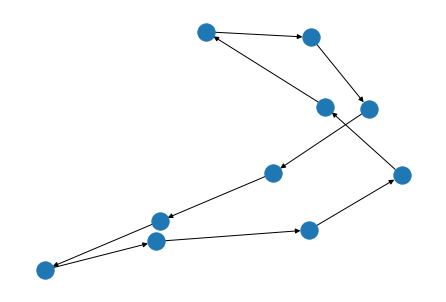

In [143]:
import networkx as nx
from icecream import ic
G = nx.MultiDiGraph()

nodeIDs = [n for n in range(100, 110)]

relationshipIDs = []
for i in nodeIDs:
  if i!=nodeIDs[-1]:
    relationshipIDs.append([i,i+1])
  else:
    relationshipIDs.append([i,nodeIDs[0]])

G.add_nodes_from(nodeIDs)

G.add_edges_from(relationshipIDs, color="red")

ic(G.nodes)
nx.draw(G)

# Ways to walk the graph

In [15]:
def bfs(generator):
  while True:
    try:
      print(next(generator))
    except StopIteration:
      break

# this version STOPS 1 step at the edge of an explored node (dead end)
## The naming of this function is very similar to edge_bfs(). The difference is that edge_bfs yields edges even if they extend back to an already explored node while this generator yields the edges of the tree that results from a breadth-first-search (BFS) so no edges are reported if they extend to already explored nodes. That means edge_bfs reports all edges while bfs_edges only reports those traversed by a node-based BFS. Yet another description is that bfs_edges reports the edges traversed during BFS while edge_bfs reports all edges in the order they are explored.
gen_bfs1=nx.bfs_edges(G, nodeIDs[0], reverse=False, depth_limit=None, sort_neighbors=None)

bfs(gen_bfs1)

# this version CONTINUES until it hits a loop
gen_bfs2=nx.edge_bfs(G, nodeIDs[0])
bfs(gen_bfs2)

(100, 101)
(101, 102)
(102, 103)
(103, 104)
(104, 105)
(105, 106)
(106, 107)
(107, 108)
(108, 109)
(100, 101, 0)
(101, 102, 0)
(102, 103, 0)
(103, 104, 0)
(104, 105, 0)
(105, 106, 0)
(106, 107, 0)
(107, 108, 0)
(108, 109, 0)
(109, 100, 0)


# Add attributes to nodes

In [16]:
import random
# nx.set_node_attributes(G, attribute_name, attribute_content)
for n in nodeIDs:
  for attributeName in ["name"]:
    #value[n]
    valueN=random.random()
    nx.set_node_attributes(G, {n: valueN}, name=attributeName)
  print(G.nodes[n][attributeName])

0.49040323837067434
0.8705198974786011
0.9560813135351721
0.891109463183702
0.7464054304345992
0.38940917681746023
0.6501136337711922
0.059355690024499363
0.5772605929339373
0.08345168527804059


# Add labels to nodes for showing the graph

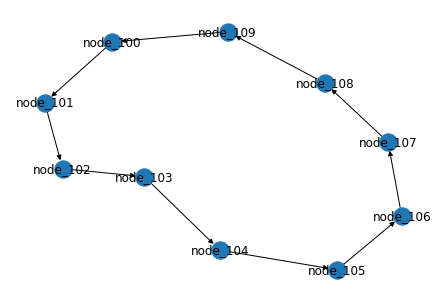

In [18]:
labeldict = {}

for n in nodeIDs:
  labeldict[n] = f"node_{n}"

nx.draw(G, labels=labeldict, with_labels = True)

# Walk the taco taxonomy

## Create taxonomy

ic| G.nodes: NodeView(('237dc3cafb60466282d673ecc674c62f', '24599b53b89448d5a1680e9d58b2ea3b', '30ad6276d0a14ed0a677ada58b5c0f55', 'd9dfa677c3644cb48ae0b3c266e50d31', 'a2e7fc38d43c49bdba2134211f2f0a42', 'dd99da2d164749aa9aa2867092bbf07a', '05eb9c30955f4243b05d87dd143e79a2', '1dc8e733121a4b01a7e695442add0c59', '7c968a91dec74a39b47124b9e2c560dc', '1e8387ca0f0e48088ab92e083e8a777e', 'a58bd468d49e41b294d95e78d8fdab74', 'dbbe8f5675934dc29f47ef7e3968d14c', '1afd766ec4734bcb97992510b1a2e847', '1e36e2dccf8a4bae8903aed9630c1094', '5385b32b083d4666902a668e195d5dc2', 'a5f63ab01d7540ccb44c9346eb9238f8', 'f487ce4d2f064742a65193e2436eff4c', '5f5e76e2c1ef4b87b877d159a231d7a7'))


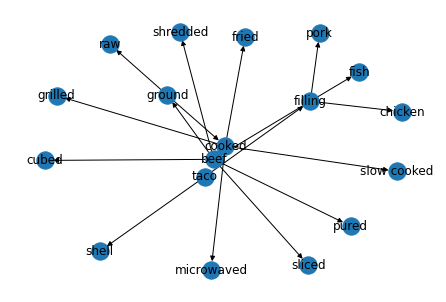

In [144]:
import networkx as nx
from icecream import ic

def taxonomy2networkx(t:Taxonomy):
  G = nx.MultiDiGraph()

  nodeIDs = t.getTaxonomyNodes()

  labeldict = {}
  for node in nodeIDs:
    labeldict[node.getId()]=node.getAttribute("name")
    G.add_node(node.getId())

  relationships = t.getTaxonomyRelationships()
  relationshipIDs=[]
  for r in relationships:
    relationshipIDs.append([r.getSourceNodeId(),r.getTargetNodeId()])

  G.add_edges_from(relationshipIDs, color="red")
  return G,labeldict

G,labeldict = taxonomy2networkx(taco_taxonomy)
ic(G.nodes)
nx.draw(G, labels=labeldict, with_labels = True)

## Walk taxonomy

In [149]:
import numpy as np

inv_map = {v: k for k, v in labeldict.items()}
taco_node = inv_map['taco']
startNode = taco_node
graphToWalk = nx.bfs_edges(G, startNode, reverse=False, depth_limit=None, sort_neighbors=None)

def id_2_name(nodeID):
  return labeldict[nodeID]

def buildTaxonomyRelationshipIndex(relationships:[NodeRelationship]):
  taxonomyRelationshipIndex={}
  for r in relationships:
    aKey = (r.sourceNodeId,r.targetNodeId)
    #print(aKey)
    taxonomyRelationshipIndex[aKey]=r
  return taxonomyRelationshipIndex

def buildTaxonomyNodeIndex(nodes:[Node]):
  taxonomyNodeIndex={}
  for n in nodes:
    taxonomyNodeIndex[n.getId()]=n
  return taxonomyNodeIndex

# tagDatabase={}

def bfs_names(generator,taxonomy,labeldict,queryResponseIndex):
  taxonomyNodeIndex = buildTaxonomyNodeIndex(
      taxonomy.getTaxonomyNodes())
  taxonomyRelationshipIndex = buildTaxonomyRelationshipIndex(
      taxonomy.getTaxonomyRelationships())
  while True:
    try:
      edge = next(generator)
      rel = taxonomyRelationshipIndex[edge]
      #print(taxonomyRelationshipIndex[edge].getAttributesList())
      
      #multType = str(rel.getMultiplicity()).split(".")[1]
      #rtype=     str(rel.getNodeRelationshipType()).split(".")[1]
      
      type0=str(taxonomyNodeIndex[edge[0]].getAttribute("NodeType")).split(".")[1]
      type1=str(taxonomyNodeIndex[edge[1]].getAttribute("NodeType")).split(".")[1]

      print(f"Expand on {type0} {labeldict[edge[0]]} find IDs for {type1} {labeldict[edge[1]]}")
    except StopIteration:
      break

#TODO: MAKE THIS REAL BY CONNECTING IT TO THE DATA PIPELINE AND NEO4J
def queryResponseMock(aQuery):
  amount = np.random.randint(1, high=5, dtype=int)
  return [Pattern().getId() for _ in range(amount)]

print("POPULATE GRAPH")

def expansionQuery(name,taxonomyNode,queryResponseIndex):
  if len(queryResponseIndex.keys())==0:
    print(f"Query data pipeline for {name} (data expansion)")
    print(f"Query neo4j for nodeIDs related to {name}")
    queryResponseIndex[startNode]=queryResponseMock(taxonomyNode)
    print("NodeIDs response from cypher query =  ", queryResponseIndex[startNode])
   #Given THING taco find IDs that THING shell
  return

queryResponseIndex={}
expansionQuery(id_2_name(startNode),startNode,queryResponseIndex)
walker = bfs_names(graphToWalk,taco_taxonomy,labeldict,queryResponseIndex)

print("QUERY GRAPH")
print("cypher query version of taxonomy")

def generateMatchStatement(taxonomy:Taxonomy):
  taxonomyNodeIndex = buildTaxonomyNodeIndex(
      taxonomy.getTaxonomyNodes())
  componentList=[]

  # TODO: apply any additional relationship constraints, if they exist from the class RelationshipConstraint
  relConstraints = taxonomy.getRelationshipConstraints()
  for rCon in relConstraints:
    sourceNode=taxonomyNodeIndex[rCon.sourceNodeId]
    targetNode=taxonomyNodeIndex[rCon.targetNodeId]
    
  ######## COMPLETE THE PART USING THE LINE ABOVE #######

  relationships=taxonomy.getTaxonomyRelationships()
  requiredRelationships=[]
  for r in relationships:
    if r.getMultiplicity() == NodeRelationshipMultiplicityConstraint.ONE_TO_ONE_OR_MORE:
      requiredRelationships.append(r)
  
  for rr in requiredRelationships:
    sourceNode=taxonomyNodeIndex[rr.sourceNodeId]
    targetNode=taxonomyNodeIndex[rr.targetNodeId]
    
    sourceNodeType = str(sourceNode.getAttribute("NodeType")).split(".")[1]
    targetNodeType = str(sourceNode.getAttribute("NodeType")).split(".")[1]
    relType = str(rr.getNodeRelationshipType()).split(".")[1]
    component=f"({rr.sourceNodeId}:{sourceNodeType})-[:{relType}]-({rr.targetNodeId}:{targetNodeType})"
    componentList.append(component)
  
  relationshipMatches=",".join(componentList)
  
  return f"MATCH {relationshipMatches}"

def generateOptionalMatchStatement(taxonomy:Taxonomy):
  relationships=taxonomy.getTaxonomyRelationships()
  taxonomyNodeIndex = buildTaxonomyNodeIndex(
      taxonomy.getTaxonomyNodes())

  optionalRelationships=[]
  for r in relationships:
    if r.getMultiplicity() in [NodeRelationshipMultiplicityConstraint.MANY_TO_MANY, NodeRelationshipMultiplicityConstraint.ONE_TO_ZERO_OR_MORE]:
      optionalRelationships.append(r)
  
  componentList=[]
  for ore in optionalRelationships:
    sourceNode=taxonomyNodeIndex[ore.sourceNodeId]
    targetNode=taxonomyNodeIndex[ore.targetNodeId]
    
    sourceNodeType = str(sourceNode.getAttribute("NodeType")).split(".")[1]
    targetNodeType = str(sourceNode.getAttribute("NodeType")).split(".")[1]
    relType = str(ore.getNodeRelationshipType()).split(".")[1]
    component=f"({ore.sourceNodeId}:{sourceNodeType})-[:{relType}]-({ore.targetNodeId}:{targetNodeType})"
    componentList.append(component)
  
  optionalRelationshipMatches=",".join(componentList)
  
  return f"OPTIONAL MATCH {optionalRelationshipMatches}"

def generateWhereStatement(taxonomy:Taxonomy,queryResponseIndex):
  
  componentList=["1=1"]
  # TODO: force each node into a set of possible IDs

  # Apply any additional node constraints, if they exist from the class NodeConstraint in the taxonomy
  nodeConstraints = taxonomy.getNodeConstraints()

  for nc in nodeConstraints:
    affectedNodeId = nc.getAffectedNodeId()
    attrName = nc.getConstrainedAttributeName()
    defn = nc.getConstraintDefinition() # EXAMPLE: ">= 15"
    componentList.append(f"{affectedNodeId}.{attrName} {defn}")
  whereClauses=" AND ".join(componentList)
  return f"WHERE {whereClauses} \nRETURN DISTINCT *;"

print(generateMatchStatement(taco_taxonomy))
print(generateOptionalMatchStatement(taco_taxonomy))
print(generateWhereStatement(taco_taxonomy,queryResponseIndex))

# HOW TO ADD OPTIONAL MULTIPLICITY CONSTRAINT
# MATCH (n123:Person {name: 'John Doe'})
# OPTIONAL MATCH (n123)-->(x)
# RETURN *

# HOW TO ADD relationshipConstraints
# MATCH (c123:City)-[:IN]-(c456:Country) #<== THESE ARE THE CONSTRAINTS for relationship between c123 and c456
# RETURN DISTINCT *;

# HOW TO ADD LIST OF relationshipConstraints
# MATCH (n123:City)-[:IN]-(n456:Country), (n999:Person)-[:IN]-(n123:Country)
# RETURN DISTINCT *;

# HOW TO ADD nodeConstraints
# MATCH (c)
# WHERE c:City AND c:Country #<== THESE ARE THE CONSTRAINTS for node c
# RETURN DISTINCT *;

### ANOTHER NODE CONSTRAINT EXAMPLE
# MATCH (n123:Person)
# WHERE n123.age >= 15 AND n123.employmentYears <= 5 #<=== WE NEED TO COLLECT UP THE WHERE CLAUSES
# RETURN *;

POPULATE GRAPH
Query data pipeline for taco (data expansion)
Query neo4j for nodeIDs related to taco
NodeIDs response from cypher query =   ['401119e4f17c4e1d939bdcca8065c400', '094fed9f7ac94707802b28eb8a0476e9', '67fe7a9451ad4e3eb3727d965f30cfe9']
Expand on THING taco find IDs for THING shell
Expand on THING taco find IDs for THING filling
Expand on THING filling find IDs for THING beef
Expand on THING filling find IDs for THING fish
Expand on THING filling find IDs for THING chicken
Expand on THING filling find IDs for THING pork
Expand on THING beef find IDs for THING ground
Expand on THING beef find IDs for THING sliced
Expand on THING beef find IDs for THING shredded
Expand on THING beef find IDs for THING cubed
Expand on THING beef find IDs for THING pured
Expand on THING ground find IDs for THING raw
Expand on THING ground find IDs for THING cooked
Expand on THING cooked find IDs for THING fried
Expand on THING cooked find IDs for THING slow cooked
Expand on THING cooked find ID

In [94]:
# this gist looks promising: https://gist.github.com/aanastasiou/6099561

import random
import networkx

#Simple character lists
letDCT = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
numDCT = "0123456789"

# this will be UUIDs
def getRndTag(someLen, dct=letDCT):
    """Returns some random string of length someLen composed of the characters in the dct string"""
    return "".join([dct[random.randint(0,len(dct)-1)] for i in range(0,someLen)])
    
def graph2Cypher(aGraph):
    """Generates a Cypher query from a Networkx Graph"""
    nodeStatements = {}
    edgeStatements = []
    
    #Partially generate the node representations
    for aNode in G.nodes(data = True):
        #Generate a node identifier for Cypher
        varName = getRndTag(2)+getRndTag(2,dct=numDCT)
        #Append the node's ID attribute so that the node-ID information used by Networkx is preserved.
        nodeItems = [("ID","%s" % aNode[0])]
        nodeItems.extend(aNode[1].items())
        #Create the key-value representation of the node's attributes taking care to add quotes when the value is of type string        
        nodeAttributes = "{%s}" % ",".join(map(lambda x:"%s:%s" %(x[0],x[1]) if not type(x[1])==str else "%s:'%s'" %(x[0],x[1]) ,nodeItems))
        #Store it to a dictionary indexed by the node-id.
        nodeStatements[aNode[0]] = [varName, "(%s %s)" % (varName, nodeAttributes)]
        
    #Generate the relationship representations
    for anEdge in G.edges(data = True):
        edgeItems = anEdge[2].items()
        edgeAttributes = ""
        if len(edgeItems)>0:
            edgeAttributes = "{%s}" % ",".join(map(lambda x:"%s:%s" %(x[0],x[1]) if not type(x[1])==str else "%s:'%s'" %(x[0],x[1]) ,edgeItems))
        #NOTE: Declare the links by their Cypher node-identifier rather than their Networkx node identifier
        edgeStatements.append("(%s)-[:LINKED_TO %s]->(%s)" % (nodeStatements[anEdge[0]][0], edgeAttributes, nodeStatements[anEdge[1]][0]))
        
    #Put both definitions together and return the create statement.
    return "create %s,%s;\n" % (",".join(map(lambda x:x[1][1],nodeStatements.items())),",".join(edgeStatements))

print(graph2Cypher(G))

create (UD63 {ID:'4388e82ecb554657a913713bb3db7fb9'}),(WS56 {ID:'61f5959167704c45a07d4ed23f2acd2f'}),(PN18 {ID:'d1a46aad0d9f47099f6cd90f2b67dcd9'}),(RT32 {ID:'4f3082b22ba44c9285b14adf7fc14611'}),(TJ29 {ID:'868ab2848f8f488e83a8ede680f9807c'}),(FX08 {ID:'4f2b93c9845d4cfe8988b5a727757d70'}),(IP88 {ID:'d53b803de10e42ac818466e86fce345e'}),(QA06 {ID:'c5aef8df01284c30ab3824ab1b5cf649'}),(FF35 {ID:'c28ad239bfe14e058c5510cfbd9fee0d'}),(RQ91 {ID:'2e33bef92856466baabfab1e3743f277'}),(IT09 {ID:'4f924fa256df4d638f3c28f4f4aadb5a'}),(DD80 {ID:'50719074046e4464bfa50a3b9f222879'}),(VD89 {ID:'0a53af3f4ccb4480b1a407c82a001cc0'}),(FS00 {ID:'18ed422bdbc746ff833afd3df29022f5'}),(PJ01 {ID:'dcb24d891f444cceb966fe4f796575d2'}),(ZN38 {ID:'93ae44404e8f4719b94937016d56e63b'}),(OM57 {ID:'6ac7924f14604ea2bd9db046fe240a95'}),(UO61 {ID:'1a1b580382a24062ab69d4d1b261e089'}),(UD63)-[:LINKED_TO {color:'red'}]->(WS56),(UD63)-[:LINKED_TO {color:'red'}]->(PN18),(PN18)-[:LINKED_TO {color:'red'}]->(RT32),(PN18)-[:LINKED_TO {c

3

In [47]:
t.getTaxonomyRelationships()

# Scratch

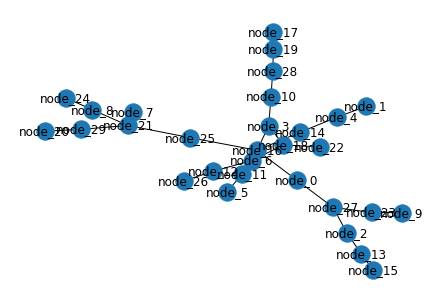

In [ ]:
# Make a random labeled tree
t = nx.random_tree(30, seed=None, create_using=None)
labeldict = {}
for n in t.nodes:
  labeldict[n] = f"node_{n}"
# nx.draw(t)
nx.draw(t, labels=labeldict, with_labels = True)

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[100, 101, 102, 104, 105, 106, 107, 108, 109]


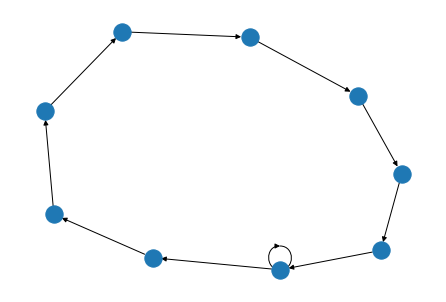

In [ ]:
#Currently unused: remove a node
# contracted_nodes: https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.minors.contracted_nodes.html
# merge a node and see the result
print(G.nodes)
new_G = nx.contracted_nodes(G,102,103)
print(new_G.nodes)
nx.draw(new_G)